#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


## Lab. 05 - Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

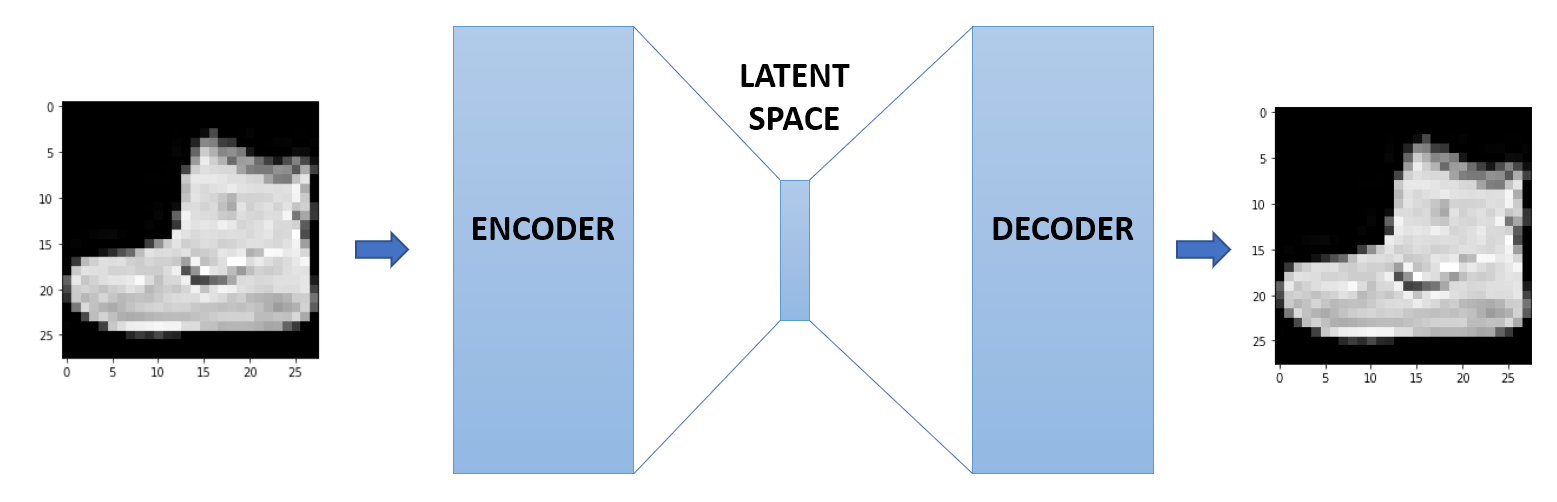

The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be **unsupervised** since we are using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.

In [1]:
# !pip install numpy
# !pip pip3 install torch torchvision torchaudio
# !pip install tqdm
# !pip install matplotlib
# !pip install scikit-image
# !pip install scipy
# !pip install scikit-learn
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install tensorboard
 

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

For this lab. we will use one of the dataset already included in PyTorch ([https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)).

**NOTE:** These dataset do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The Fashion MNIST dataset is a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [3]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

The output of the dataset is a PIL Image, a standard format for image processing, but we can easily convert the data to a numpy array:
```
image_numpy = np.array(pil_image)
```
or to a PyTorch tensor:
```
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(pil_image)
```


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

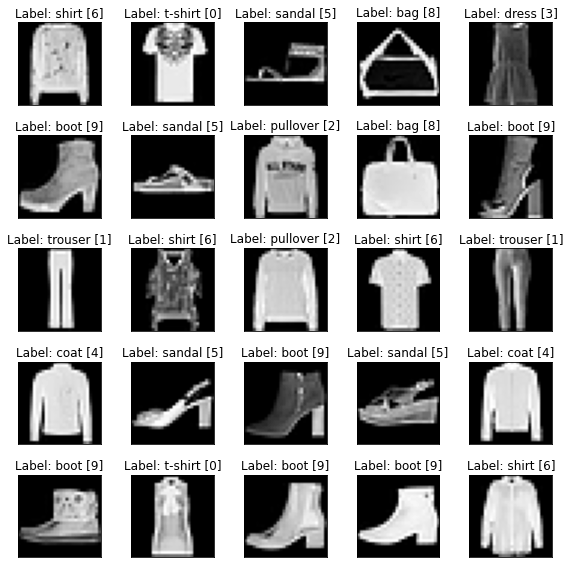

In [4]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [5]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


Since we already defined our datasets, this is an alternative (and recommended) way to add (or modify) a dataset transformation without reinitializing the dataset (very useful when the dataset initialization is slow):

In [6]:
# check what is going on BEFORE the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(<PIL.Image.Image image mode=L size=28x28 at 0x7F51FDEC4C50>, 9)
<PIL.Image.Image image mode=L size=28x28 at 0x7F51FDEC4B50>
9


In [7]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [8]:
# check what is going on AFTER the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [9]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

Let's start from the encoder. In the figure you can find a suggested architecture for the encoder, with all the required parameters for each layer.

In this example we are considering a latent space with just **2 variables**, so make sure your encoder generates tensors with the proper shape.

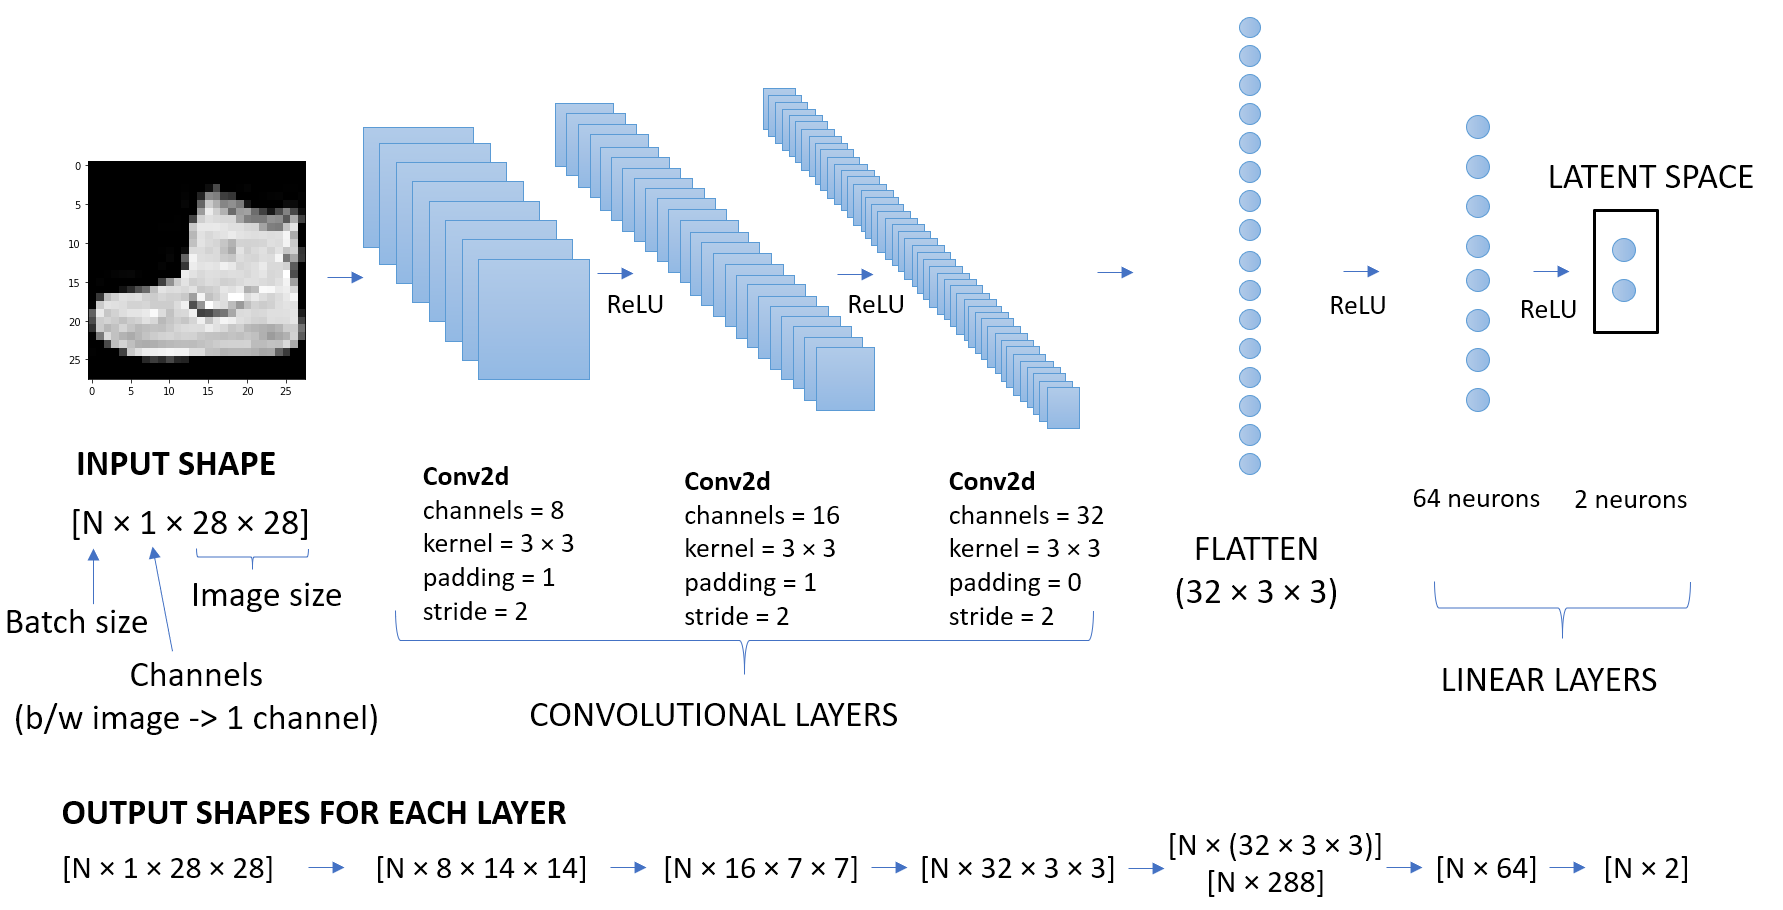

`torch.nn.Sequential` is a utility function that allows to easily concatenate sequential layers, without defining a separate object for each of them (more details here: [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

The output of a convolutional layer is typically multi-dimensional. To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array. This operation is often referred to as **flattening**. In PyTorch, this can be done with the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)
 layer. By setting `start_dim = 1` we keep the first axis (index 0) as it is (which represents the batch size in our case, that should not be flattened) and all the other axes will be flattened in the new second axis.


In [10]:
# TODO: fill the holes with the number from the above figure.

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer

            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=2)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## Decoder

Typically the structure of the decoder is specular with respect to the encoder, but this is not a strict requirement. Some successful implementations use very different architectures for the encoder and the decoder. 

The only requirement of the decoder is the input shape, which must match the latent space, and the output shape, that must match the input image. 

In this example we implement a decoder perfectly matched with the encoder architecture, but reversed.

Since the convolutional layers in the encoder perform a down-scaling, we need up-scaling layers in the decoder. To this end we use **transposed convolutions**, already available in PyTorch with the [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer.

Similarly to the `torch.nn.Flatten` layer, the [`torch.nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html?highlight=unflatten#torch.nn.Unflatten) layer does the opposite operation. We take the axis at index 1 (`dim=1`) and we reshape it to the proper shape (`unflattened_size=(32, 3, 3)`).

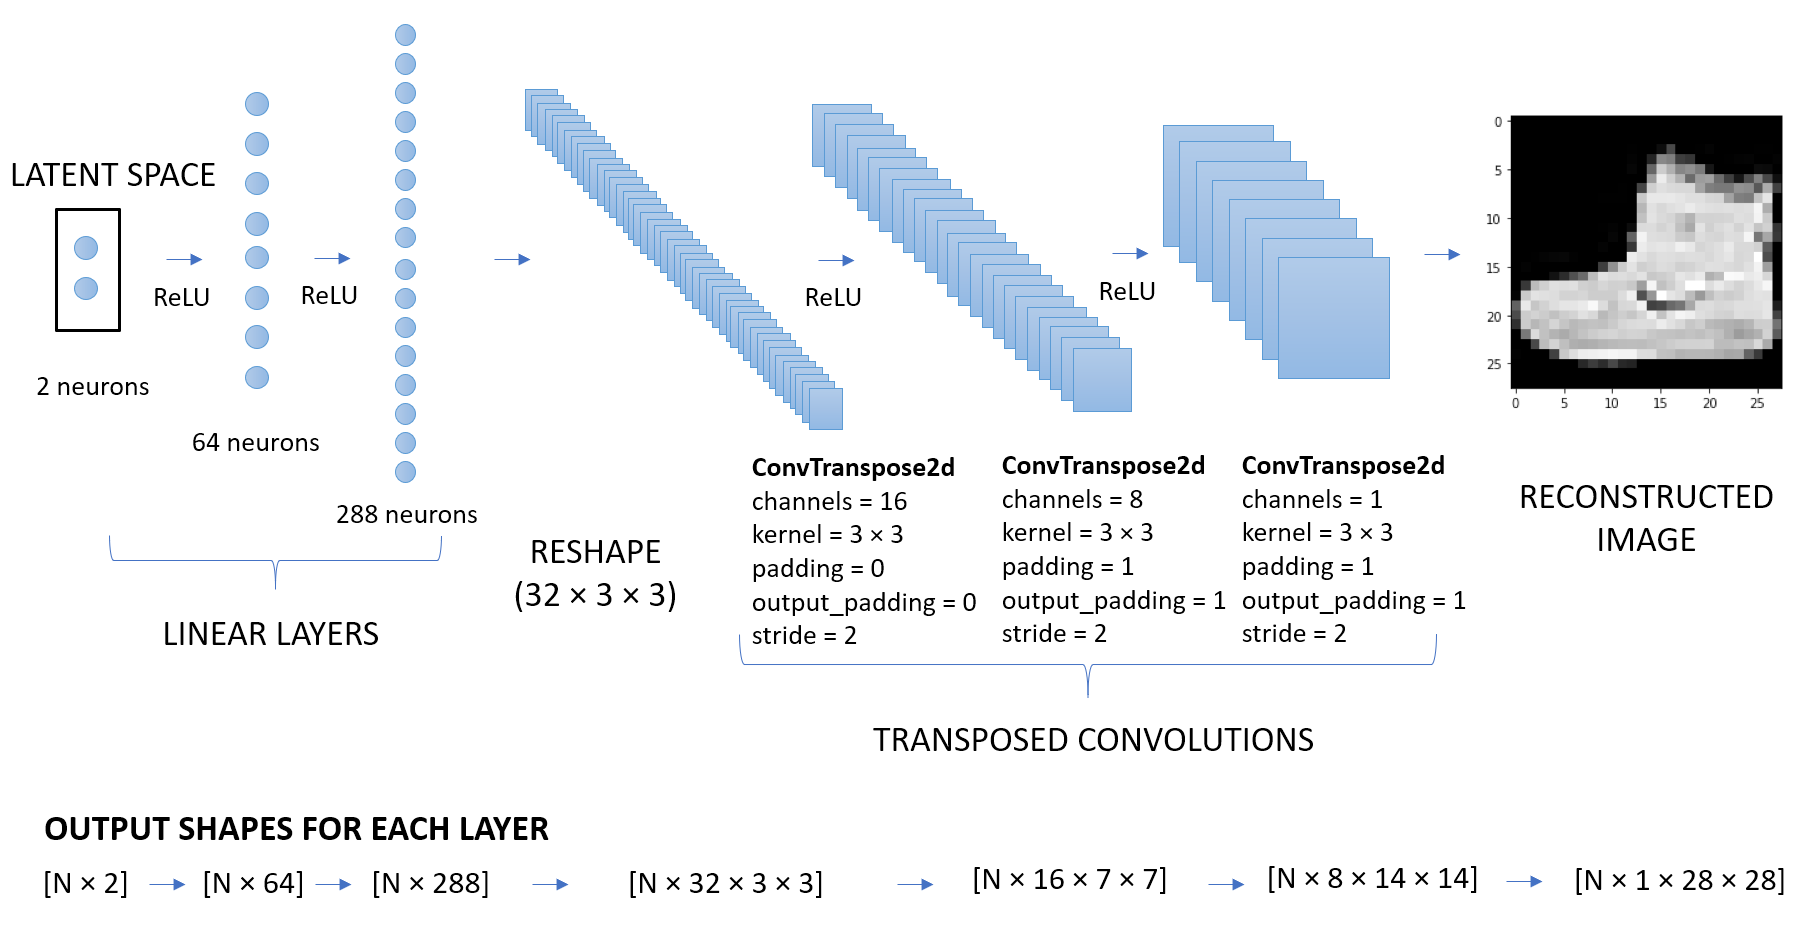

In [11]:
# TODO: fill the holes with the number from the above figure.

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [12]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [13]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axisfig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

The training is similar to the previous examples. The only difference is that now we have 2 different networks. In this situation you have 2 choices:
*   Use a single optimizer to train the parameters of both networks.
*   Define a separate optimizer for each network, and update both of them in the training loop.

In this case we define a single optimizer for both networks, by just providing a list of the required parameters to the optimizer (see the code below).

You can find more details for all the possible scenarios [here](https://pytorch.org/docs/stable/optim.html).

In [14]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing funcion. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [15]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in tqdm(dataloader): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add loss to the list
        train_loss.append(loss.data.detach().cpu().numpy())
    train_loss = np.mean(train_loss)
    print(f"partial train loss (mean of the epoch): {train_loss}")

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [16]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happen during the training, we also show the output corresponding to a specific image at the end of each epoch.

EPOCH 1/10


100%|██████████| 235/235 [00:11<00:00, 20.21it/s]


partial train loss (mean of the epoch): 0.10404133796691895


	 VALIDATION - EPOCH 1/10 - loss: 0.059874




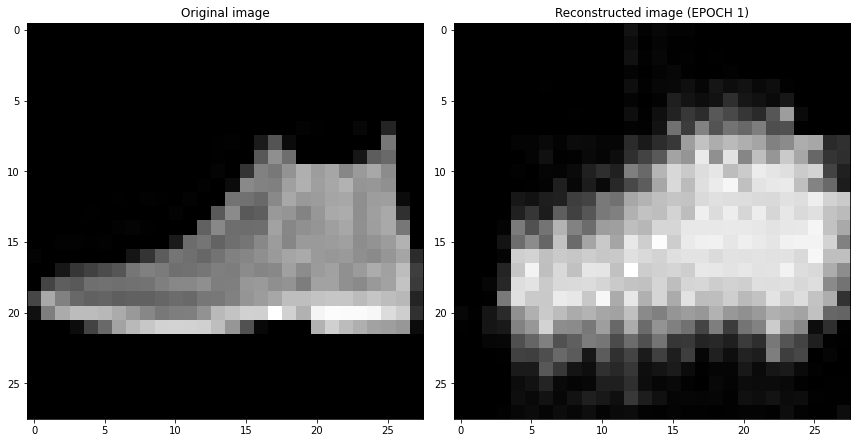

EPOCH 2/10


100%|██████████| 235/235 [00:11<00:00, 21.16it/s]


partial train loss (mean of the epoch): 0.04911219701170921


	 VALIDATION - EPOCH 2/10 - loss: 0.042179




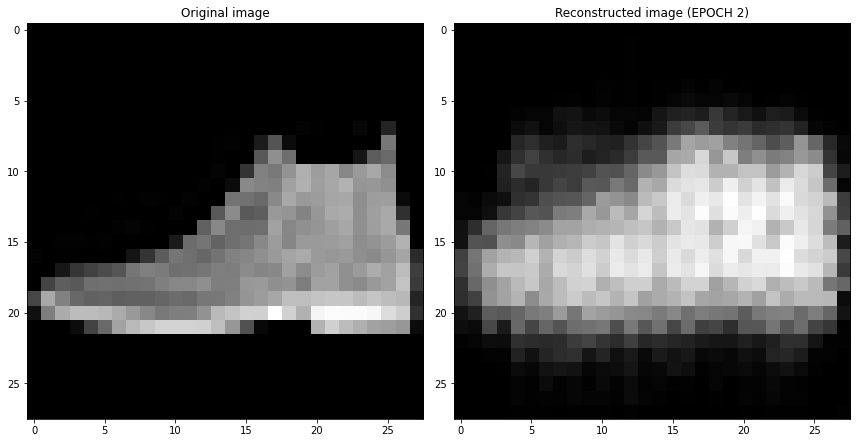

EPOCH 3/10


100%|██████████| 235/235 [00:10<00:00, 22.55it/s]


partial train loss (mean of the epoch): 0.04073866829276085


	 VALIDATION - EPOCH 3/10 - loss: 0.039237




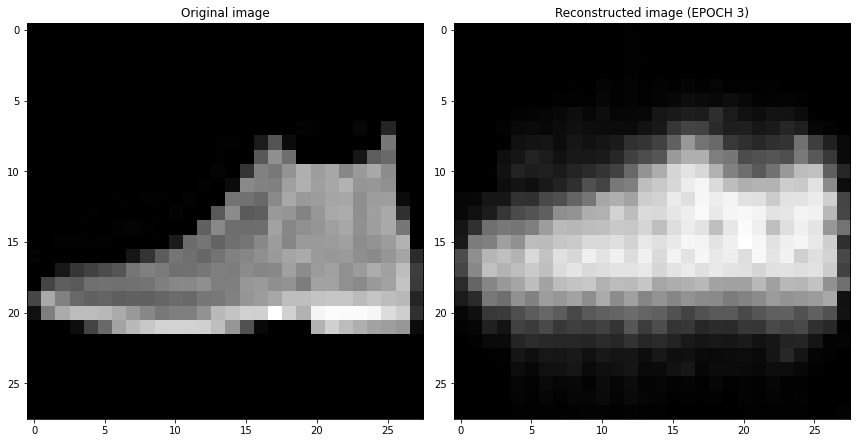

EPOCH 4/10


100%|██████████| 235/235 [00:10<00:00, 22.91it/s]


partial train loss (mean of the epoch): 0.0384635329246521


	 VALIDATION - EPOCH 4/10 - loss: 0.037402




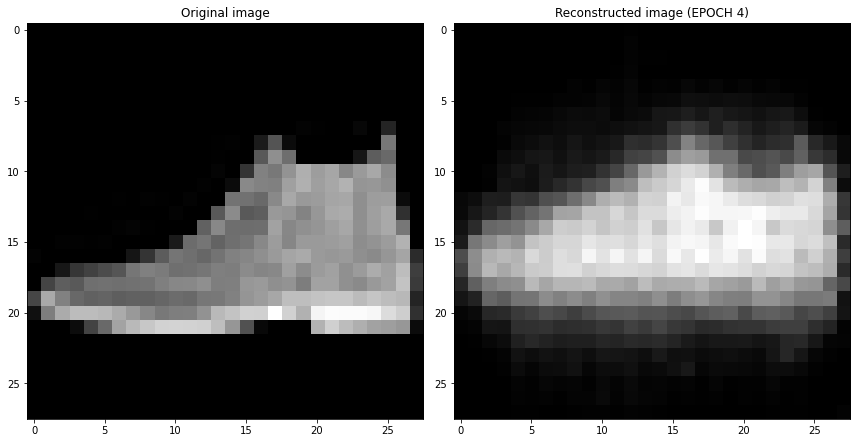

EPOCH 5/10


100%|██████████| 235/235 [00:11<00:00, 19.66it/s]


partial train loss (mean of the epoch): 0.0368049181997776


	 VALIDATION - EPOCH 5/10 - loss: 0.035864




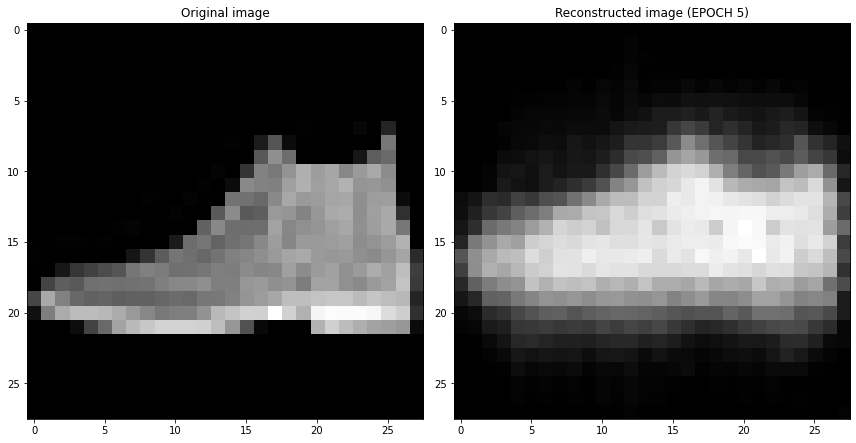

EPOCH 6/10


100%|██████████| 235/235 [00:11<00:00, 19.77it/s]


partial train loss (mean of the epoch): 0.035618990659713745


	 VALIDATION - EPOCH 6/10 - loss: 0.034656




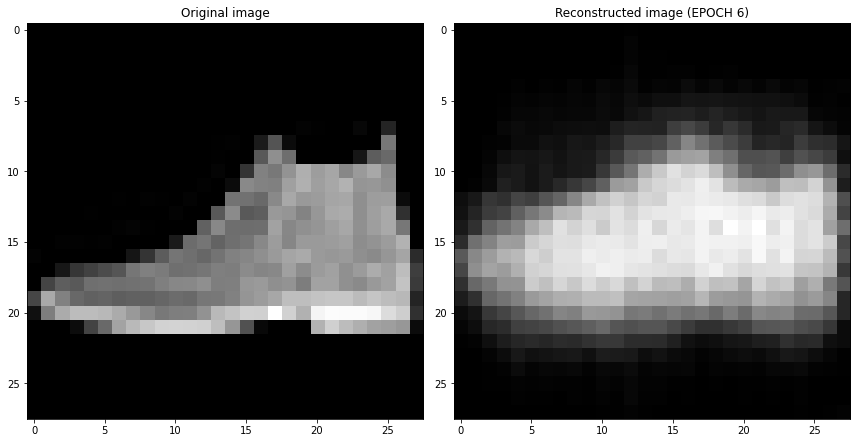

EPOCH 7/10


100%|██████████| 235/235 [00:11<00:00, 21.32it/s]


partial train loss (mean of the epoch): 0.034065864980220795


	 VALIDATION - EPOCH 7/10 - loss: 0.033497




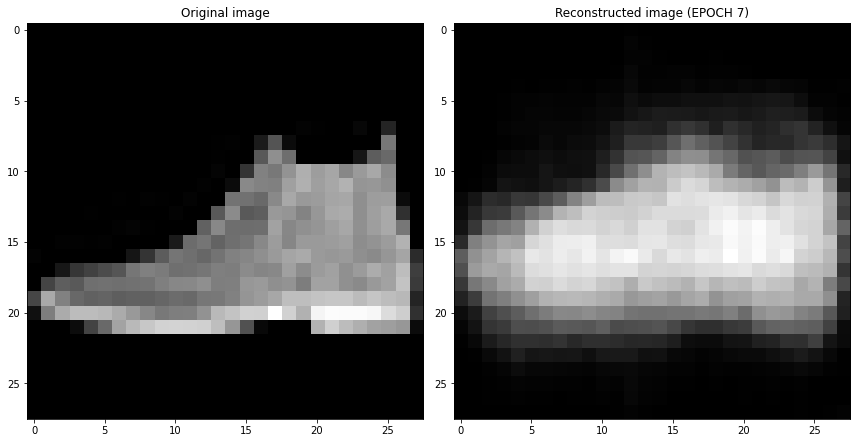

EPOCH 8/10


100%|██████████| 235/235 [00:11<00:00, 20.23it/s]


partial train loss (mean of the epoch): 0.033360064029693604


	 VALIDATION - EPOCH 8/10 - loss: 0.032972




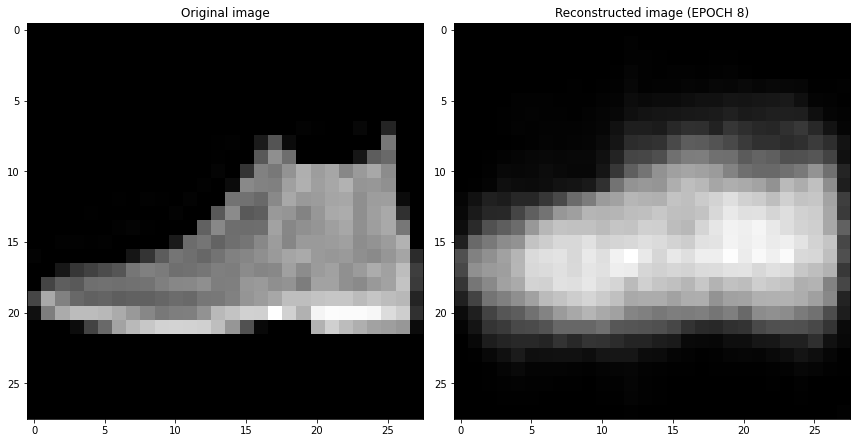

EPOCH 9/10


100%|██████████| 235/235 [00:09<00:00, 23.88it/s]


partial train loss (mean of the epoch): 0.03285716101527214


	 VALIDATION - EPOCH 9/10 - loss: 0.032473




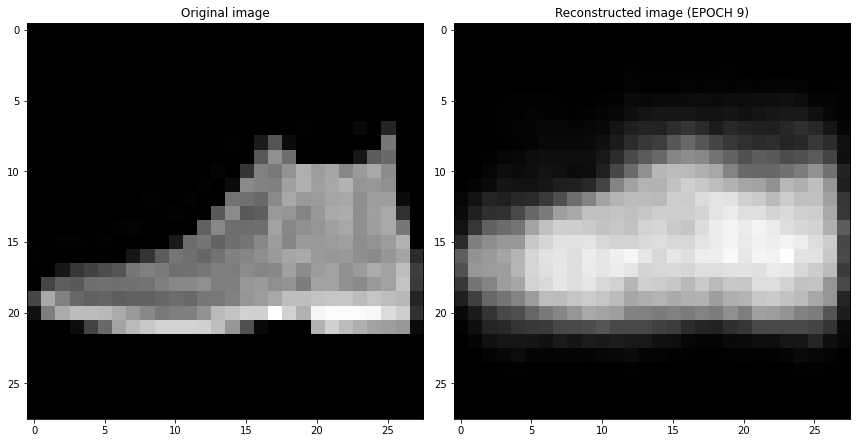

EPOCH 10/10


100%|██████████| 235/235 [00:09<00:00, 24.19it/s]


partial train loss (mean of the epoch): 0.03249847888946533


	 VALIDATION - EPOCH 10/10 - loss: 0.032103




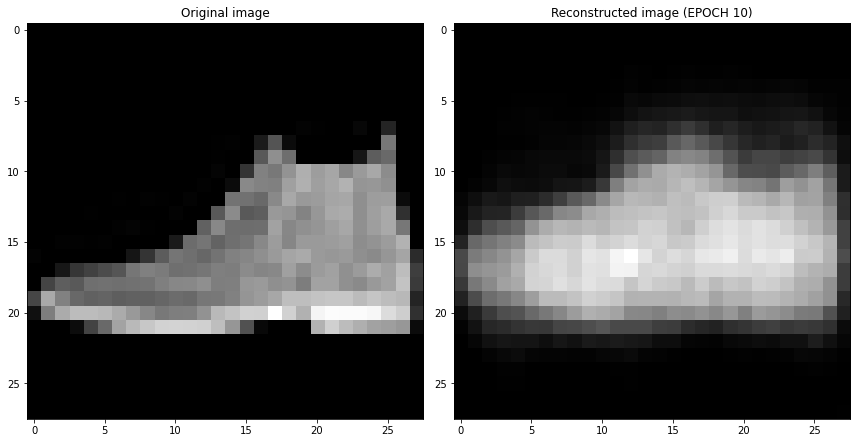

In [17]:

### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')


    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [18]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [19]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:13<00:00, 749.93it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [20]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-4.629160,-18.067396,9
1,1.712404,10.669509,2
2,-33.372971,8.629582,1
3,-36.850777,4.795242,1
4,-3.730982,-0.277115,6
...,...,...,...
9995,12.524887,-15.237843,9
9996,-29.915304,-0.626939,1
9997,-9.295881,-0.177151,8
9998,-43.486015,6.581922,1


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [21]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the id of the class in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

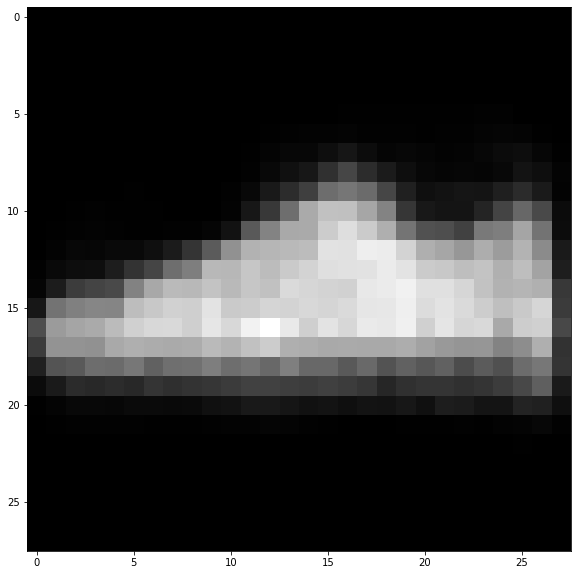

In [22]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-6, -30.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

# Further insights on PCA and t-SNE

Let's do the same training again, with encoded dimension equal to 10.

Selected device: cuda
EPOCH 1/10


100%|██████████| 235/235 [00:09<00:00, 23.96it/s]


partial train loss (mean of the epoch): 0.10416571795940399


	 VALIDATION - EPOCH 1/10 - loss: 0.060021




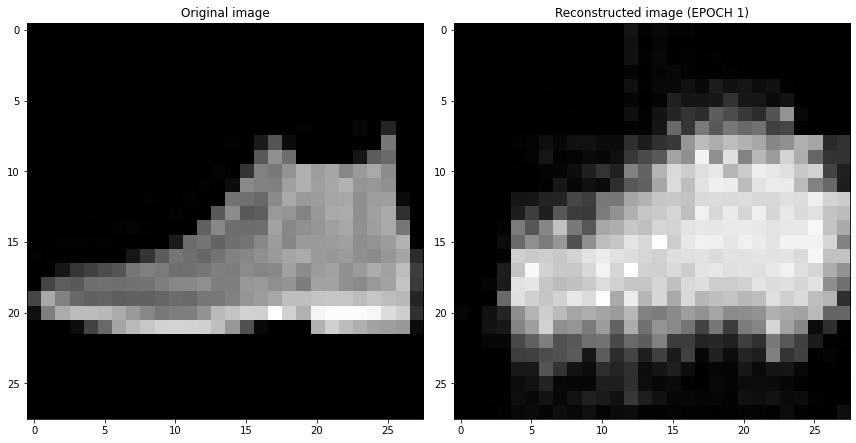

EPOCH 2/10


100%|██████████| 235/235 [00:09<00:00, 24.06it/s]


partial train loss (mean of the epoch): 0.0500517301261425


	 VALIDATION - EPOCH 2/10 - loss: 0.042313




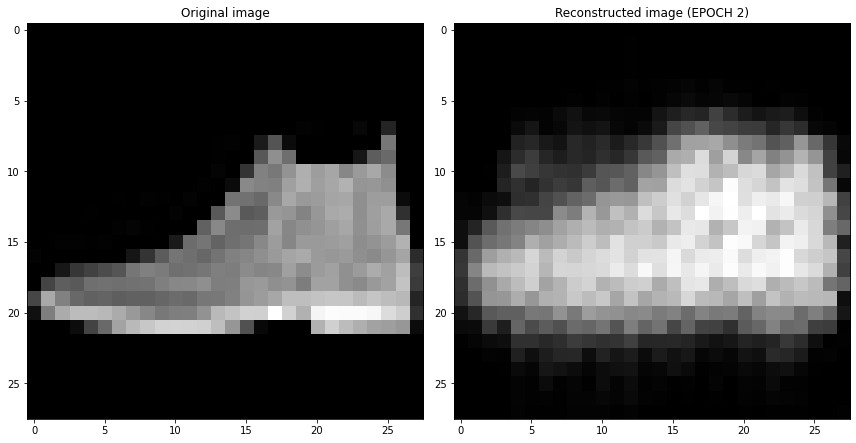

EPOCH 3/10


100%|██████████| 235/235 [00:09<00:00, 24.16it/s]


partial train loss (mean of the epoch): 0.04074446111917496


	 VALIDATION - EPOCH 3/10 - loss: 0.039174




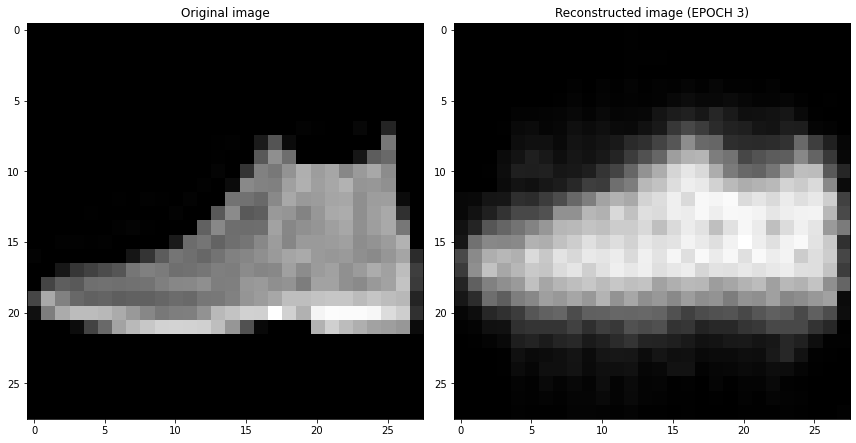

EPOCH 4/10


100%|██████████| 235/235 [00:09<00:00, 24.20it/s]


partial train loss (mean of the epoch): 0.038391437381505966


	 VALIDATION - EPOCH 4/10 - loss: 0.037370




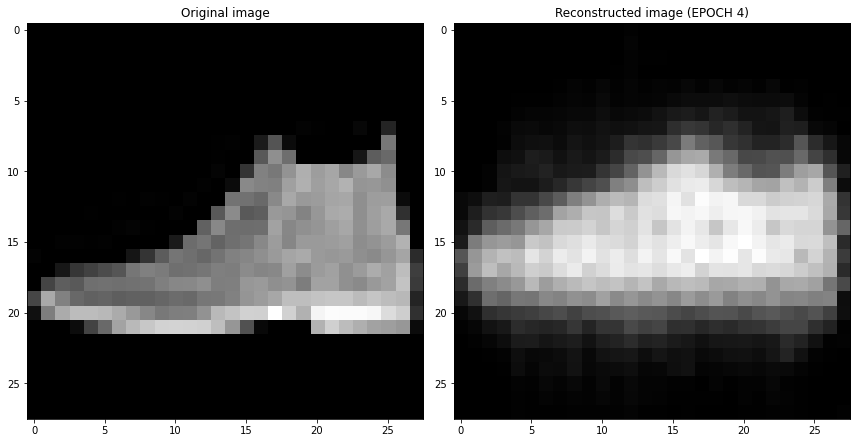

EPOCH 5/10


100%|██████████| 235/235 [00:09<00:00, 24.14it/s]


partial train loss (mean of the epoch): 0.03681294992566109


	 VALIDATION - EPOCH 5/10 - loss: 0.035603




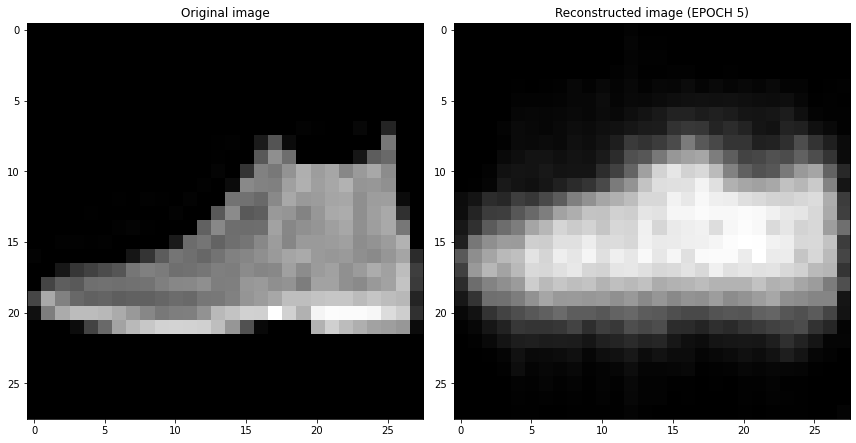

EPOCH 6/10


100%|██████████| 235/235 [00:09<00:00, 24.24it/s]


partial train loss (mean of the epoch): 0.034879669547080994


	 VALIDATION - EPOCH 6/10 - loss: 0.034086




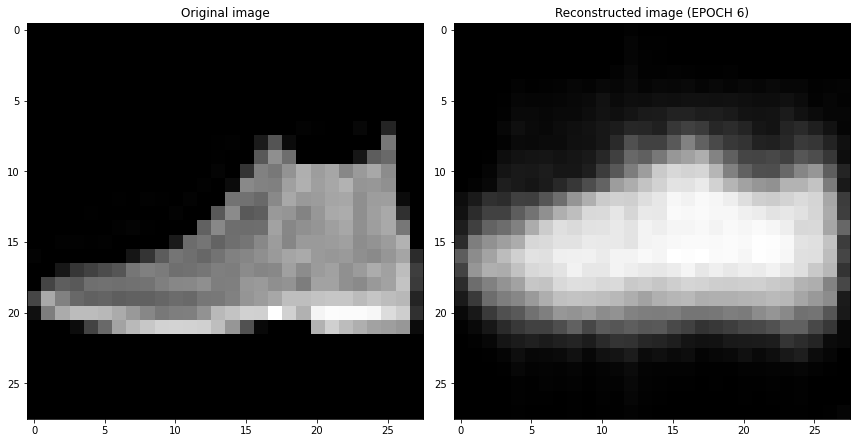

EPOCH 7/10


100%|██████████| 235/235 [00:09<00:00, 24.06it/s]


partial train loss (mean of the epoch): 0.033951763063669205


	 VALIDATION - EPOCH 7/10 - loss: 0.033345




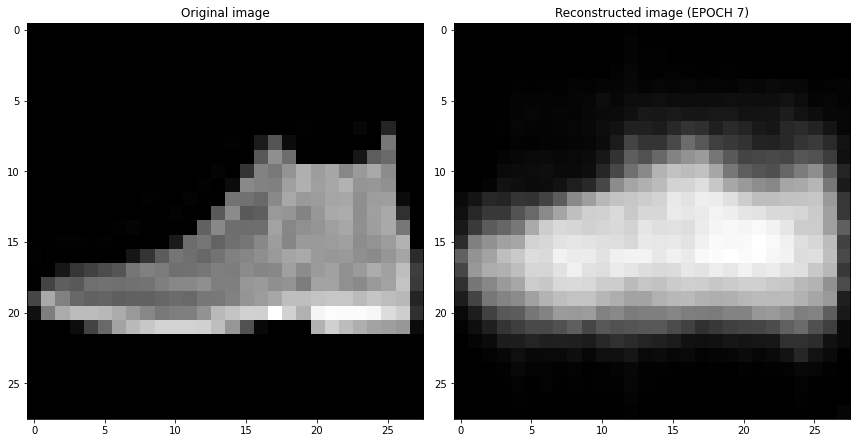

EPOCH 8/10


100%|██████████| 235/235 [00:09<00:00, 24.25it/s]


partial train loss (mean of the epoch): 0.03331253305077553


	 VALIDATION - EPOCH 8/10 - loss: 0.032885




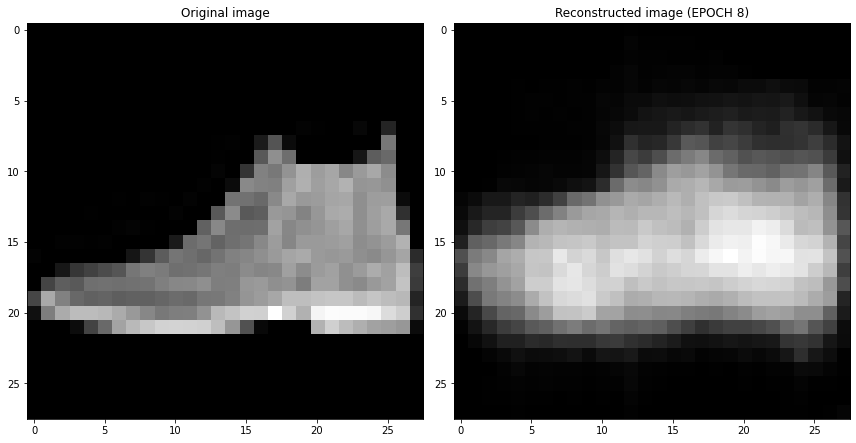

EPOCH 9/10


100%|██████████| 235/235 [00:09<00:00, 24.21it/s]


partial train loss (mean of the epoch): 0.032838087528944016


	 VALIDATION - EPOCH 9/10 - loss: 0.032475




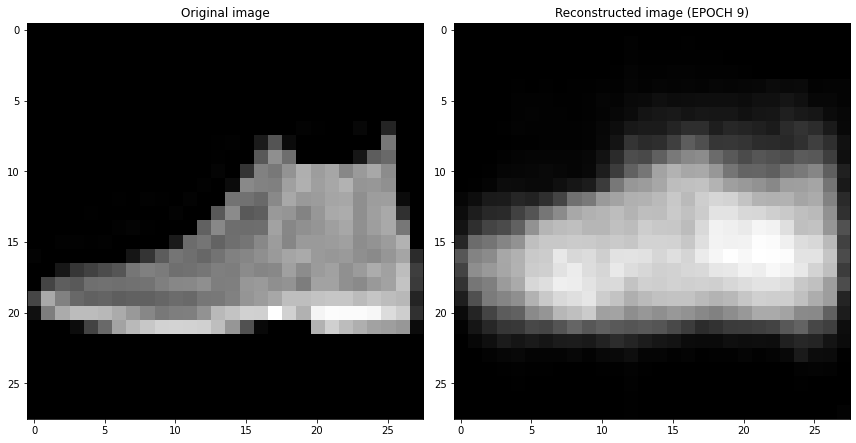

EPOCH 10/10


100%|██████████| 235/235 [00:09<00:00, 23.52it/s]


partial train loss (mean of the epoch): 0.03243640810251236


	 VALIDATION - EPOCH 10/10 - loss: 0.032068




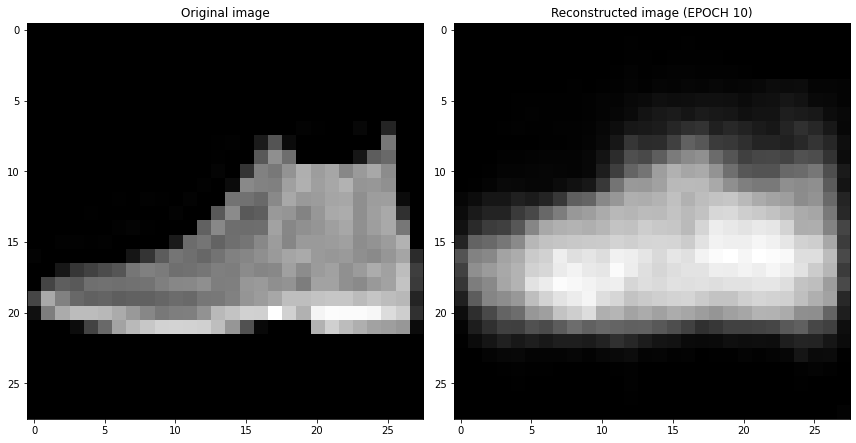

In [23]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 10  # this is the only line we change!
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)


### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

In [24]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:06<00:00, 1466.32it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,-4.721872,-17.616360,9
1,0.953963,10.840637,2
2,-37.429649,8.657125,1
3,-40.134430,4.667777,1
4,-3.878585,-1.135254,6
...,...,...,...
9995,13.864121,-16.493092,9
9996,-32.147659,-0.933216,1
9997,-9.974854,-1.357664,8
9998,-47.140865,6.610357,1


**How can we visualize data?** we like 2D-3D plots for intuition!

PCA and tSNE come into play.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

array([[-14.05675517,  -7.13783134],
       [  2.86084227,  16.91153095],
       [ 28.3268351 , -11.78431719],
       ...,
       [  1.16799493,   0.63144575],
       [ 33.68765635, -20.09799828],
       [-12.1019123 ,  -8.22575985]])

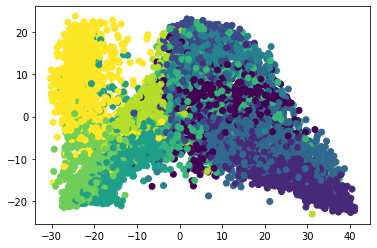

In [26]:
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



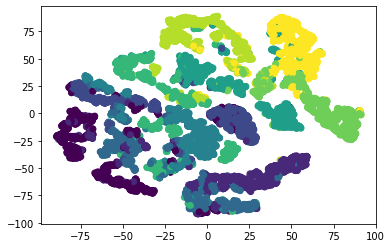

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

Given a point cloud:
*   **PCA** is like taking a snapshot from a different perspective/angle (linear only)
*   **tSNE** is like taking a snapshot from a different perspective/angle and at the same time stretching the space (non-linear)


**Autoencoders** can be used to solve a variety of different tasks!


*   Denoising images: add random noise to the training transform and want to predict the denoised image
*   Filling holes: add random holes in the image and predict the filled image
*   Image Generation: via Variational Autoencoders VAEs,...

